#Recolectar y preparar imágenes de Naves Imperiales de Star Wars



In [3]:
#@title Librerías

import sys, os, re, random
import urllib, time, base64
import urllib.parse
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

print("Librerías cargadas.")

Librerías cargadas.


#Recolectar Imágenes de Naves Imperiales
Fuente de datos: http://insd.swcombine.com/insd.htm

In [4]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/IA/demoStarWars/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [5]:
#@title Cargar URL de las imágenes obtenidos del sitio


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'navesOri.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
atributo_clase = 'Ship Type' #@param {type:"string"}
atributo_URL = 'URL_image' #@param {type:"string"}


## selección de los parámetros

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n")

# inicializa valores
classList = np.array(df[atributo_clase])
urlList = np.array(df[atributo_URL])
# sólo agrega naves con imágenes definidas
navesList = []
for c, url in zip(classList, urlList):
  if (url!="") and ("NOPIC.JPG" not in url):
    navesList.append((c, url))
print("\n Se identifican ", len(navesList), " naves para descargar imágenes.")
print("")

Archivo de datos  navesOri.csv  cargado

> Cabecera: 
                        Name     Ship Type                         Model  \
0     Law Class Patrol Craft  Patrol Craft  Law Class Light Patrol Craft   
1  Lambda Class T-4a Shuttle      Shuttles     Lambda Class T-4a Shuttle   
2               TIE Defender  TIE Fighters                TIE/df Fighter   
3         Nebulon-B2 Frigate  Medium Ships            Nebulon-B2 Frigate   
4               TIE Defender  TIE Fighters               TIE/opp Fighter   

           Manufacturer      Length                              Crew  \
0      Kuat Drive Yards   51 meters                                15   
1     Cygnus Spaceworks   20 meters  2-4 (Depending on configuration)   
2  Sienar Fleet Systems  9.2 meters                                 1   
3      Kuat Drive Yards  253 meters                             1,120   
4  Sienar Fleet Systems  9.2 meters                                 1   

                              Troops  \
0         


- Clases cargadas:  104
- Imágenes cargadas:  104
- Cantidad por clase: 
	 TIE Bombers: 6
	 TIE Experimental Craft: 5
	 TIE Support Craft: 10
	 Landing Craft: 7
	 Command Ships: 3
	 Medium Ships: 14
	 TIE Fighters: 20
	 Patrol Craft: 5
	 Other Starfighters: 10
	 Shuttles: 6
	 Heavy Ships: 14
	 Transporters: 4

- Ejemplo  Patrol Craft   (300, 300, 3) : 


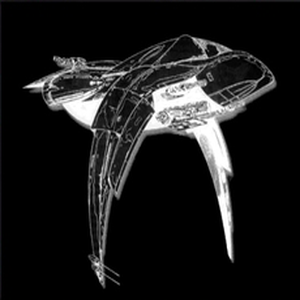

In [20]:
#@title Recuperar imágenes de las naves

#@markdown ### Parámetros de imágenes:
imagen_largo = 300 #@param {type:"integer"}
imagen_ancho = 300 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}


#@markdown ### Recorte recuadro
recortar_recuadro = True #@param {type:"boolean"}
sacar_recuadro_superior = 35 #@param {type:"integer"}
sacar_recuadro_izquierdo = 20 #@param {type:"integer"}
sacar_recuadro_derecho = 50 #@param {type:"integer"}
sacar_recuadro_inferior = 55 #@param {type:"integer"}
recuperar_solo_una = False #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_largo<=10:
  imagen_largo = 10
if imagen_ancho<=10:
  imagen_ancho = 10
IMAGE_SHAPE = (imagen_largo, imagen_ancho, (3 if imagen_color else 1))

if recortar_recuadro:
  IMAGE_CROP = (sacar_recuadro_izquierdo, sacar_recuadro_superior, imagen_ancho-sacar_recuadro_derecho, imagen_largo-sacar_recuadro_inferior)
else:
  IMAGE_CROP = None


# define tamaño de datos de entrada
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

import requests # request img from web
import shutil # save img locally

# define función para cargar las imágenes
def cargarImagenes(navesList, IMAGE_CROP, procesa_solo_primera=False):
  classes_ori = []
  images_ori = []
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  i = 0
  for nave in navesList:
        # obtiene datos de la imagen
        each_imagURL = nave[1]
        if each_imagURL != "":
          imagClass = nave[0]
          i = i + 1

          # baja la imagen
          URL_file_name = "./download_image_"+str(i)+".jpg"
          res = requests.get(each_imagURL, stream = True)
          if res.status_code == 200:
              with open(URL_file_name,'wb') as f:
                  shutil.copyfileobj(res.raw, f)
          else:
              print('No se puede descargar la imagen')

          # abre la imagen
          imag = Image.open(URL_file_name)

          # ajusta el tamaño
          imag = imag.convert(tipoImage)
          imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

          if IMAGE_CROP is not None:
            imag = imag.crop(IMAGE_CROP)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

          # transforma a un vector de nros
          arImag = np.array(imag)

          # agrega a los vectores
          classes_ori.append( imagClass )
          images_ori.append( arImag )

          # si es la primera
          if procesa_solo_primera:
            break

  return classes_ori, images_ori, tipoImage

def mostrar_cant_por_clase(classList):
  aux = list(set(classList))
  print("- Cantidad por clase: ")
  for c in aux:
    print("\t " + str(c) + ": " + str(classList.count(c)))
  print("")

# carga las imagenes de entrenamiento
classes_ori, images_ori, tipoImage_ori = cargarImagenes(navesList, IMAGE_CROP, recuperar_solo_una)

print("")
print("- Clases cargadas: ", len(classes_ori))
print("- Imágenes cargadas: ", len(images_ori))
mostrar_cant_por_clase(classes_ori)


if len(images_ori)>0:
  print("- Ejemplo ", classes_ori[0], " ", images_ori[0].shape, ": ")
  display( Image.fromarray(images_ori[0], tipoImage_ori) )



(1)-  Patrol Craft   (300, 300, 3) : 


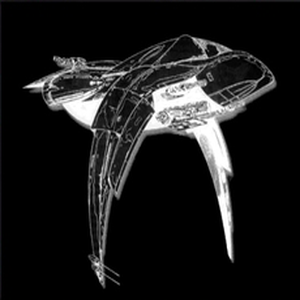


(2)-  Shuttles   (300, 300, 3) : 


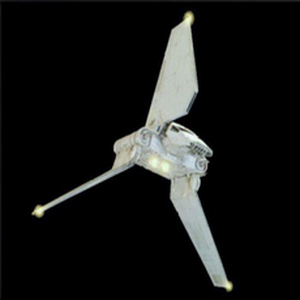


(3)-  TIE Fighters   (300, 300, 3) : 


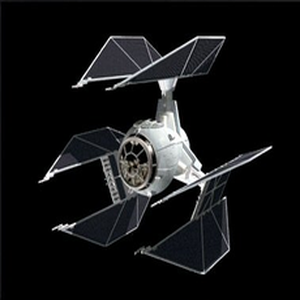


(4)-  Medium Ships   (300, 300, 3) : 


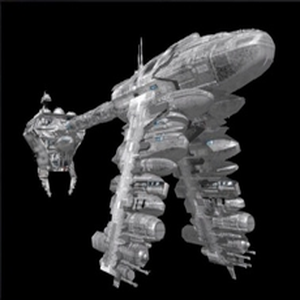


(5)-  TIE Fighters   (300, 300, 3) : 


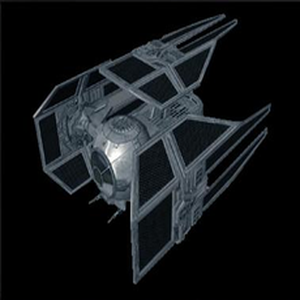


(6)-  TIE Support Craft   (300, 300, 3) : 


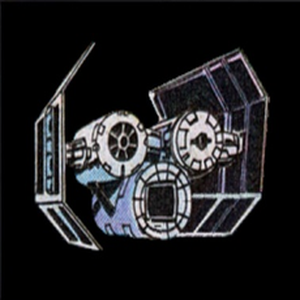


(7)-  Other Starfighters   (300, 300, 3) : 


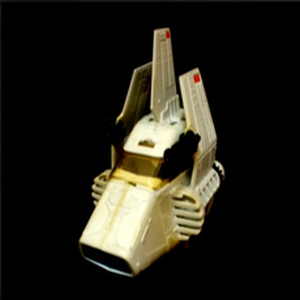


(8)-  TIE Support Craft   (300, 300, 3) : 


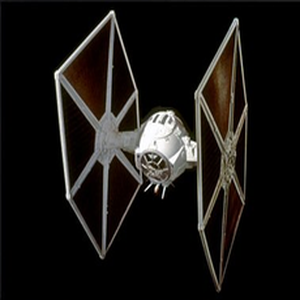


(9)-  TIE Bombers   (300, 300, 3) : 


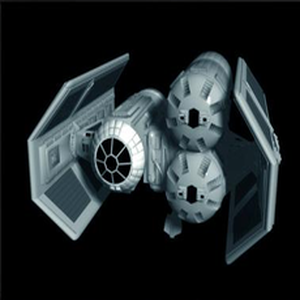


(10)-  Heavy Ships   (300, 300, 3) : 


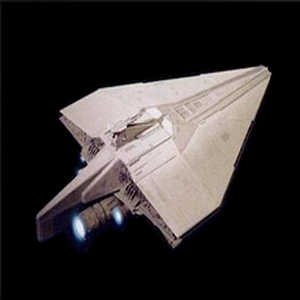


(11)-  TIE Fighters   (300, 300, 3) : 


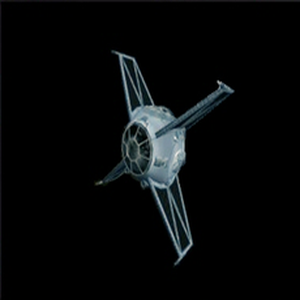


(12)-  Other Starfighters   (300, 300, 3) : 


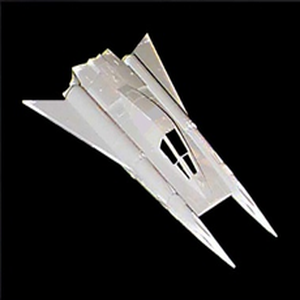


(13)-  Medium Ships   (300, 300, 3) : 


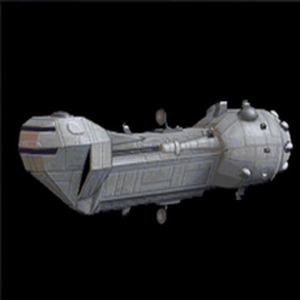


(14)-  Heavy Ships   (300, 300, 3) : 


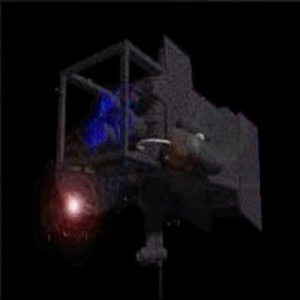


(15)-  TIE Support Craft   (300, 300, 3) : 


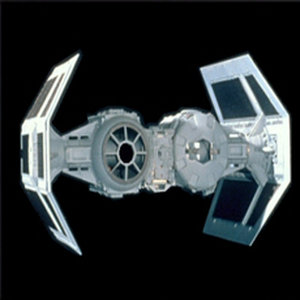


(16)-  Landing Craft   (300, 300, 3) : 


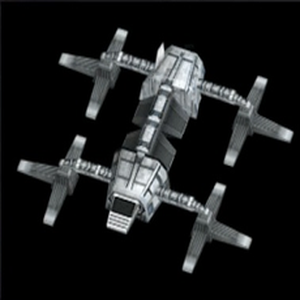


(17)-  Medium Ships   (300, 300, 3) : 


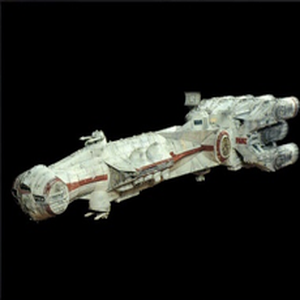


(18)-  TIE Support Craft   (300, 300, 3) : 


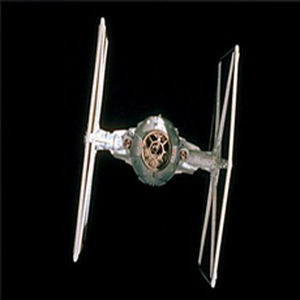


(19)-  Landing Craft   (300, 300, 3) : 


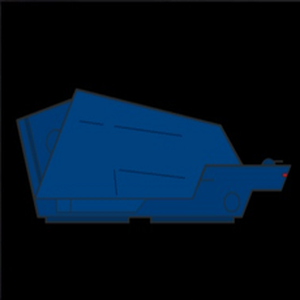


(20)-  TIE Bombers   (300, 300, 3) : 


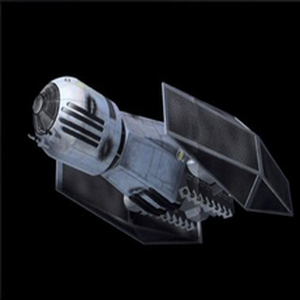


(21)-  TIE Fighters   (300, 300, 3) : 


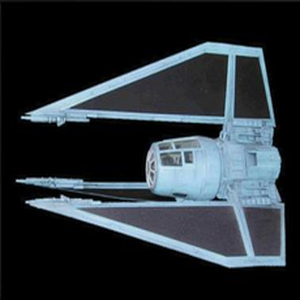


(22)-  TIE Experimental Craft   (300, 300, 3) : 


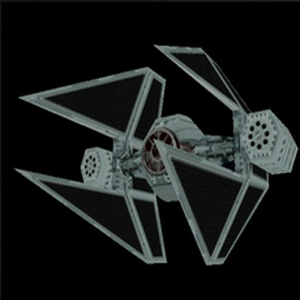


(23)-  TIE Experimental Craft   (300, 300, 3) : 


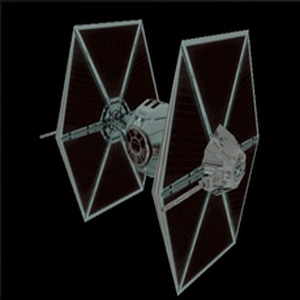


(24)-  TIE Support Craft   (300, 300, 3) : 


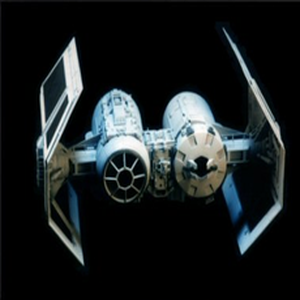


(25)-  Other Starfighters   (300, 300, 3) : 


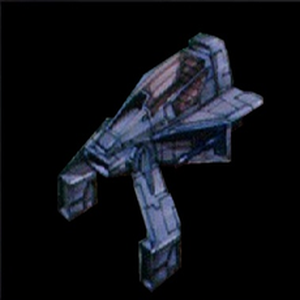

In [21]:
#@title Revisar imágenes descargadas

revisar_imagenes_cant = 25 #@param{type:"integer"}

for i in range(min(revisar_imagenes_cant, len(classes_ori))):
  print("\n("+str(i+1)+")- ", classes_ori[i], " ", images_ori[i].shape, ": ")
  display( Image.fromarray(images_ori[i], tipoImage_ori) )



#Aplicar Image Augmentation (opcional)

Ejemplo de posibles aplicaciones:


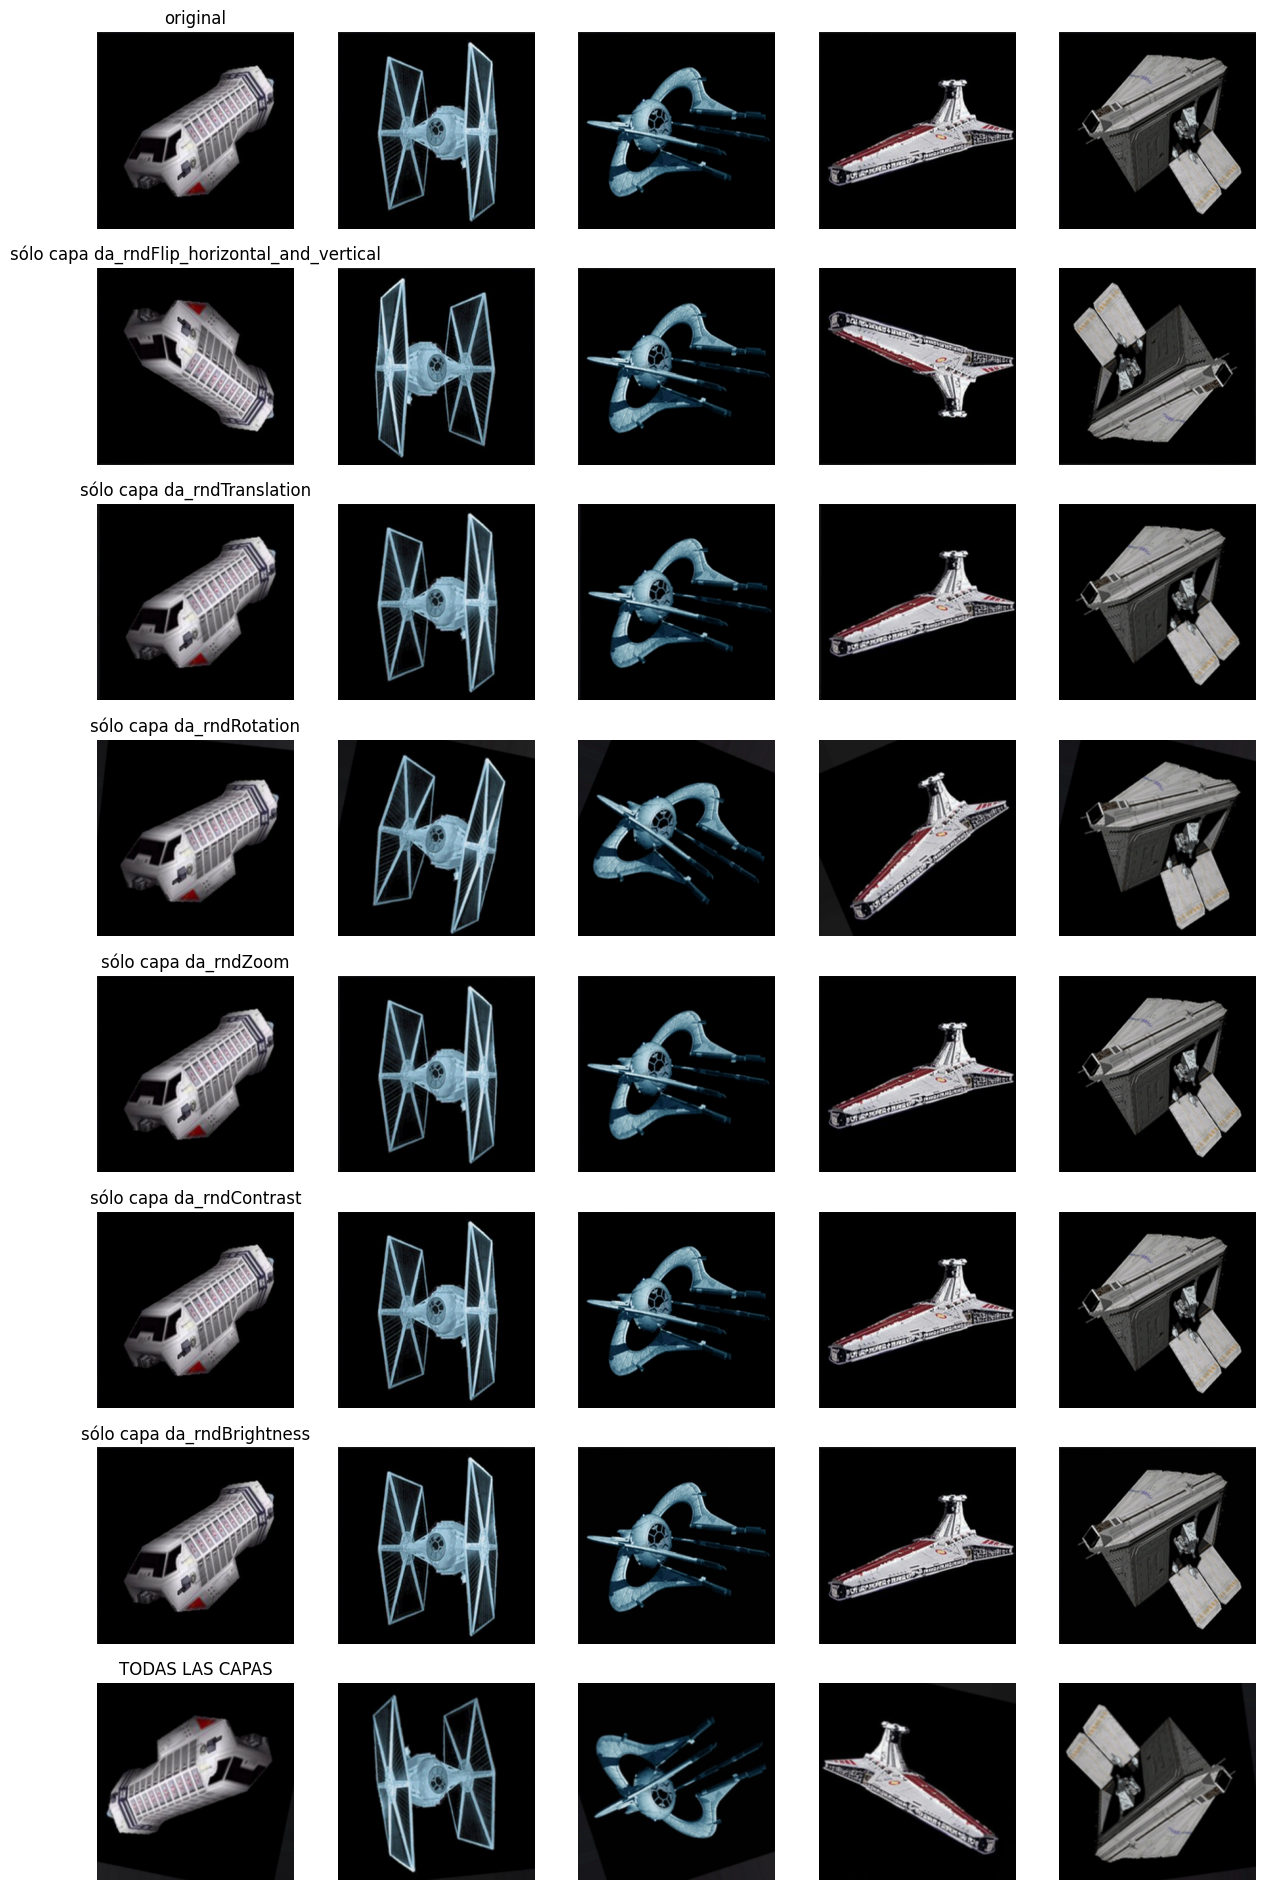

In [22]:
#@title Definición configuracón para Image Augmentation (opcional)

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

aplicar_da_preProcesamiento = True #@param {type:"boolean"}

da_preProcesamiento_RandomFlip_Horizontal = True #@param {type:"boolean"}
da_preProcesamiento_RandomFlip_Vertical = True #@param {type:"boolean"}
da_preProcesamiento_RandomTranslation_Horizontal_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomTranslation_Vertical_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomRotation_factor = 0.1 #@param {type:"number"}
da_preProcesamiento_RandomZoom_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomContrast_factor = 0.01 #@param {type:"number"}
da_preProcesamiento_RandomBrightness_factor = 0.01 #@param {type:"number"}

daLayers_modelo = []

# capas de data augmentation (solo para training)
if aplicar_da_preProcesamiento:

  if da_preProcesamiento_RandomFlip_Horizontal or da_preProcesamiento_RandomFlip_Vertical:
    if da_preProcesamiento_RandomFlip_Horizontal:
      modeDAFlip = "horizontal"
      if da_preProcesamiento_RandomFlip_Vertical:
        modeDAFlip = modeDAFlip + "_and_vertical"
    else:
      modeDAFlip = "vertical"
    daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

  if (da_preProcesamiento_RandomTranslation_Horizontal_factor != 0.0) or (da_preProcesamiento_RandomTranslation_Vertical_factor != 0.0):
    daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_preProcesamiento_RandomTranslation_Vertical_factor/100, width_factor=da_preProcesamiento_RandomTranslation_Horizontal_factor, name="da_rndTranslation", fill_mode="nearest") )

  if da_preProcesamiento_RandomRotation_factor != 0.0:
      daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_preProcesamiento_RandomRotation_factor, name="da_rndRotation", fill_mode="nearest") )

  if da_preProcesamiento_RandomZoom_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_preProcesamiento_RandomZoom_factor, name="da_rndZoom", fill_mode="nearest") )

  if da_preProcesamiento_RandomContrast_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_preProcesamiento_RandomContrast_factor, name="da_rndContrast") )

  if da_preProcesamiento_RandomBrightness_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_preProcesamiento_RandomBrightness_factor, name="da_rndBrightness") )

# Visualize images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))

  j = 0
  for j in range(5):

    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(images_ori))
    im = images_ori[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay(im).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    for da_lay in daLayers_modelo:
        im = da_lay(im)

    ax[i][j].imshow(im.numpy().astype("uint8"))
    if j == 0:
      ax[i][j].set_title("TODAS LAS CAPAS")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

In [60]:
#@title Generar imágenes con Image Augmentation (opcional)

cant_variaciones_generar_da_preProcesamiento = 20 #@param{type:"integer"}
intentar_balancear_clases = True #@param {type:"boolean"}

# inicializa variables
clases_newDA = []
images_newDA = []
cant = 0
cantTotal = 0

if aplicar_da_preProcesamiento and (cant_variaciones_generar_da_preProcesamiento>0):

  # inicializa cantidad por clase
  aux = list(set(classes_ori))
  cantGenerarClases = {}
  clMasImagenes = None
  clMasImagenes_cant = 0
  for cl in aux:
    cantActual = classes_ori.count(cl)
    cantGenerarClases[cl] = [cantActual, cantActual*cant_variaciones_generar_da_preProcesamiento, cant_variaciones_generar_da_preProcesamiento]
    # determina clase con más imágenes
    if (clMasImagenes is None) or (clMasImagenes_cant < cantActual):
      clMasImagenes = cl
      clMasImagenes_cant = cantActual


  # identifica maxima cantidad de imágenes a generar
  cantMaxGenerar = cantGenerarClases[clMasImagenes][0] + cantGenerarClases[clMasImagenes][1]

  print("- Cantidad a generar por clase: ")
  for cl in cantGenerarClases.keys():
    if intentar_balancear_clases:
      # determina cuántas imágenes se generan de la clase para intentar balancearlas
      cantGenerarClases[cl][1] = cantMaxGenerar - cantGenerarClases[cl][0]
      cantGenerarClases[cl][2] = (cantGenerarClases[cl][1]//cantGenerarClases[cl][0]) + 1
    cantTotal += cantGenerarClases[cl][1]
    print("\t " + ("*" if (clMasImagenes == cl) else "") + str(cl) + ": actual " + str(cantGenerarClases[cl][0]) + " + a generar " + str(cantGenerarClases[cl][1]) + " --> " + str(cantGenerarClases[cl][0]+cantGenerarClases[cl][1]) )
  print("")

  print("-- Comenzando a generar ", cantTotal," variaciones de imágenes...")
  for cl, im in zip(classes_ori, images_ori):
    for _ in range(cantGenerarClases[cl][2]):
      if (cantGenerarClases[cl][1]<=0):
        break
      # aplica todas las capas
      for da_lay in daLayers_modelo:
          im = da_lay(im)
      # agrega
      clases_newDA.append( cl )
      images_newDA.append( im.numpy().astype("uint8") )
      # contabiliza
      cant += 1
      cantGenerarClases[cl][1] -= 1
      if (cant % (cantTotal//20)) == 0:
        print("\t... ya se generaron ", cant, " imágenes...")

  print("\n > Se agregaron " + str(len(clases_newDA)) + " nuevas variaciones de las imágenes recolectadas.")
  print("- Cantidad a generar por clase: ")
  for cl in aux:
    print("\t " + str(cl) + ": " + str(clases_newDA.count(cl)))
  print("")

- Cantidad a generar por clase: 
	 TIE Bombers: actual 6 + a generar 414 --> 420
	 TIE Experimental Craft: actual 5 + a generar 415 --> 420
	 TIE Support Craft: actual 10 + a generar 410 --> 420
	 Landing Craft: actual 7 + a generar 413 --> 420
	 Command Ships: actual 3 + a generar 417 --> 420
	 Medium Ships: actual 14 + a generar 406 --> 420
	 *TIE Fighters: actual 20 + a generar 400 --> 420
	 Patrol Craft: actual 5 + a generar 415 --> 420
	 Other Starfighters: actual 10 + a generar 410 --> 420
	 Shuttles: actual 6 + a generar 414 --> 420
	 Heavy Ships: actual 14 + a generar 406 --> 420
	 Transporters: actual 4 + a generar 416 --> 420

-- Comenzando a generar  4936  variaciones de imágenes...
	... ya se generaron  246  imágenes...
	... ya se generaron  492  imágenes...
	... ya se generaron  738  imágenes...
	... ya se generaron  984  imágenes...
	... ya se generaron  1230  imágenes...
	... ya se generaron  1476  imágenes...
	... ya se generaron  1722  imágenes...
	... ya se generaron 


(da_4709)-  Command Ships   (300, 300, 3) : 


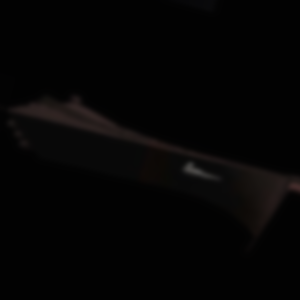


(da_2017)-  Shuttles   (300, 300, 3) : 


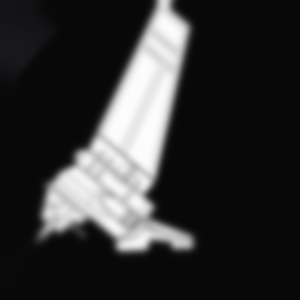


(da_4483)-  TIE Experimental Craft   (300, 300, 3) : 


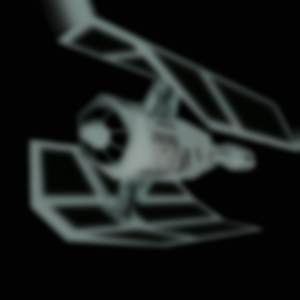


(da_2701)-  Patrol Craft   (300, 300, 3) : 


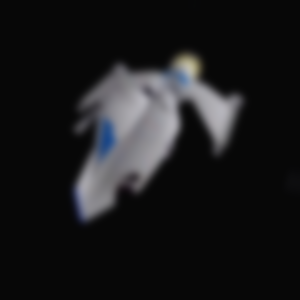


(da_1228)-  Other Starfighters   (300, 300, 3) : 


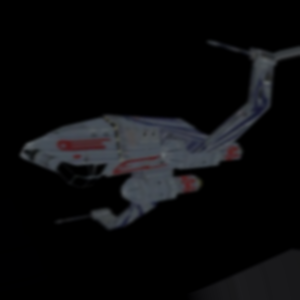


(da_374)-  TIE Bombers   (300, 300, 3) : 


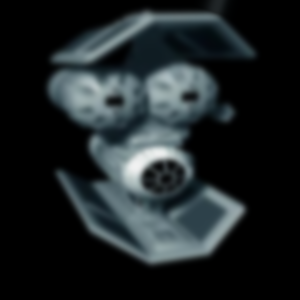


(da_4668)-  Command Ships   (300, 300, 3) : 


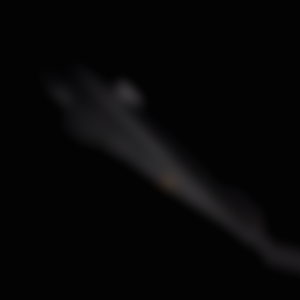


(da_3412)-  Medium Ships   (300, 300, 3) : 


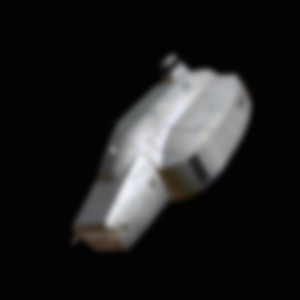


(da_2249)-  Landing Craft   (300, 300, 3) : 


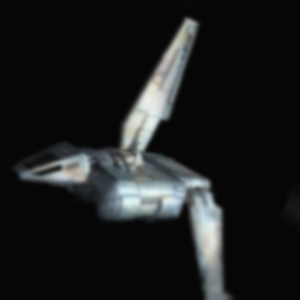


(da_1578)-  Heavy Ships   (300, 300, 3) : 


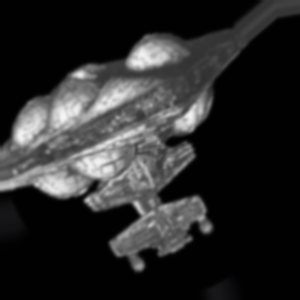


(da_2436)-  Other Starfighters   (300, 300, 3) : 


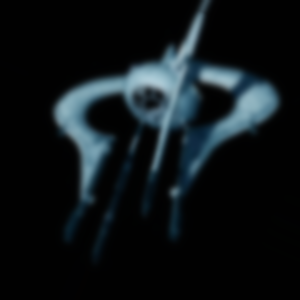


(da_1850)-  Shuttles   (300, 300, 3) : 


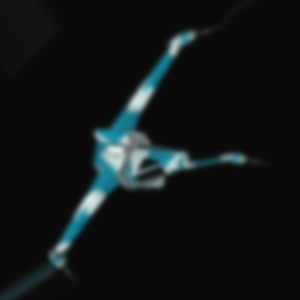


(da_327)-  TIE Support Craft   (300, 300, 3) : 


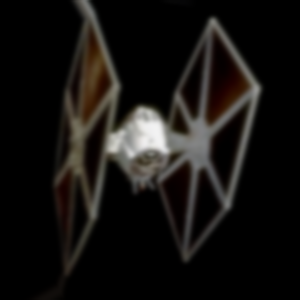


(da_3419)-  Transporters   (300, 300, 3) : 


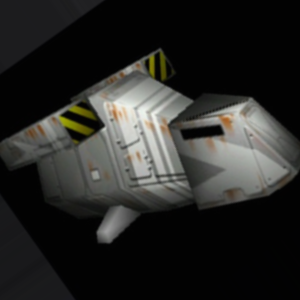


(da_378)-  TIE Bombers   (300, 300, 3) : 


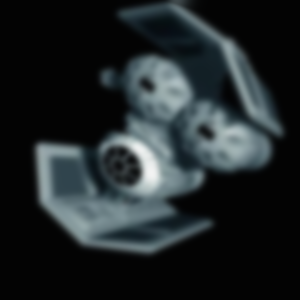


(da_1057)-  TIE Experimental Craft   (300, 300, 3) : 


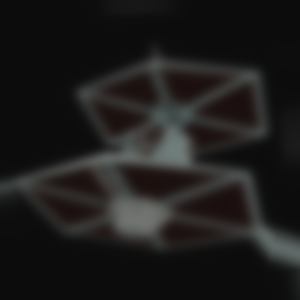


(da_4242)-  TIE Fighters   (300, 300, 3) : 


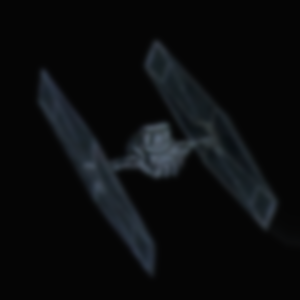


(da_1706)-  Transporters   (300, 300, 3) : 


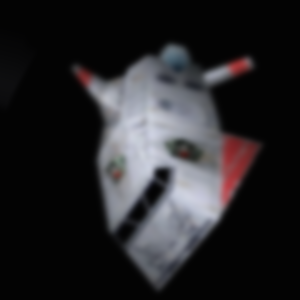


(da_1953)-  TIE Fighters   (300, 300, 3) : 


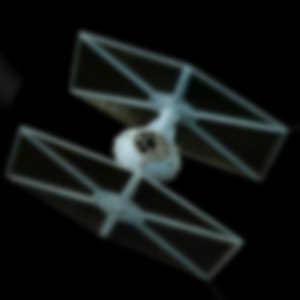


(da_3483)-  Transporters   (300, 300, 3) : 


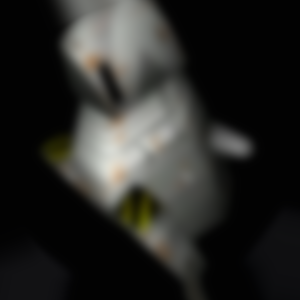

In [62]:
#@title Revisar imágenes generadas con Image Augmentation (orden al azar)

revisar_imagenes_da_cant = 20 #@param{type:"integer"}

for _ in range(min(revisar_imagenes_da_cant, len(clases_newDA))):
    i = random.randint(1, len(clases_newDA))
    print("\n(da_"+str(i+1)+")- ", clases_newDA[i], " ", images_newDA[i].shape, ": ")
    display( Image.fromarray(images_newDA[i], tipoImage_ori) )



#Divide en imágenes de Entrenamiento y Prueba

 Total de imágenes disponibles:  5040

> Para Entrenamiento: 
- Clases:  4032
- Imágenes:  4032
- Cantidad por clase: 
	 TIE Bombers: 336
	 TIE Experimental Craft: 336
	 TIE Support Craft: 336
	 Command Ships: 336
	 Landing Craft: 336
	 Medium Ships: 336
	 TIE Fighters: 336
	 Patrol Craft: 336
	 Other Starfighters: 336
	 Shuttles: 336
	 Heavy Ships: 336
	 Transporters: 336

- Ejemplo  Command Ships   (300, 300, 3) : 


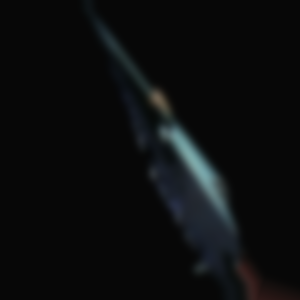



> Para Prueba: 
- Clases:  1008
- Imágenes:  1008
- Cantidad por clase: 
	 Shuttles: 84
	 TIE Bombers: 84
	 TIE Experimental Craft: 84
	 TIE Support Craft: 84
	 Command Ships: 84
	 Landing Craft: 84
	 Medium Ships: 84
	 Other Starfighters: 84
	 Patrol Craft: 84
	 TIE Fighters: 84
	 Heavy Ships: 84
	 Transporters: 84

- Ejemplo  Landing Craft   (300, 300, 3) : 


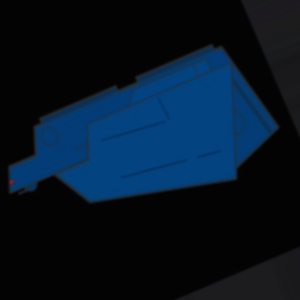

In [64]:
#@title Divide en imágenes para entrenamiento y para prueba

#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# consolida las nuevas con las recolectadas
clases_dividir = []
clases_dividir.extend(classes_ori)
clases_dividir.extend(clases_newDA)
images_dividir = []
images_dividir.extend(images_ori)
images_dividir.extend(images_newDA)
print(" Total de imágenes disponibles: ", len(clases_dividir))
print("")

# divide en imaágenes de entrenamiento y prueba
images_train, images_test, classes_train, classes_test = train_test_split(images_dividir, clases_dividir, test_size=(1-propTrain), stratify=clases_dividir)
tipoImage_train = tipoImage_ori
tipoImage_test = tipoImage_ori

print("> Para Entrenamiento: ")
print("- Clases: ", len(classes_train))
print("- Imágenes: ", len(classes_train))
mostrar_cant_por_clase(classes_train)

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
print("\n\n> Para Prueba: ")
print("- Clases: ", len(classes_test))
print("- Imágenes: ", len(images_test))
mostrar_cant_por_clase(classes_test)

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [65]:
#@title Grabar imágenes en Drive

import os
import uuid

# directorio local en Google Drive
exportar_imagenes = True  #@param {type:"boolean"}
path_imagenes = '/content/gdrive/MyDrive/IA/demoStarWars/imagenes/'  #@param {type:"string"}

def grabarImagenes(clasesList, imgList, dirPath):
  # crea directorio si no existe
  if not os.path.isdir(dirPath):
    os.mkdir(dirPath)
  # recorre los vectores y graba las imágenes
  cant = 0
  for c, i in zip(clasesList, imgList):
    pathClass = dirPath+c
    if not os.path.isdir(pathClass):
      os.mkdir(pathClass)
    imgFN = pathClass + "/" + str(uuid.uuid4().hex) + ".png"
    img = Image.fromarray(i, tipoImage_ori)
    img.save(imgFN)
    cant += 1
  print("\n> Se grabaron ", cant, "imágenes en ", dirPath)

if exportar_imagenes:
  # fuerza actualización del drive
  drive.flush_and_unmount()
  drive.mount('/content/gdrive')
  if os.path.isdir(path_imagenes):
    print("Ya existe el directorio ", path_imagenes, ": renombrelo o borrelo")
  else:
    os.mkdir(path_imagenes)
    # graba las imágenes de entrenamiento
    grabarImagenes(classes_train, images_train, path_imagenes+"train/")
    # graba las imágenes de prueba
    grabarImagenes(classes_test, images_test, path_imagenes+"test/")
    print("\nActualizando drive...")
    # fuerza actualización del drive
    drive.flush_and_unmount()
    drive.mount('/content/gdrive')
    print("\nDrive actualizado.")


Mounted at /content/gdrive

> Se grabaron  4032 imágenes en  /content/gdrive/MyDrive/IA/demoStarWars/imagenes/train/

> Se grabaron  1008 imágenes en  /content/gdrive/MyDrive/IA/demoStarWars/imagenes/test/

Actualizando drive...
Mounted at /content/gdrive

Drive actualizado.
